In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import torch.nn as nn
import torch

In [2]:
import sys
sys.path.append("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/code/")
import package

In [31]:
import importlib
importlib.reload(package.torch_classifier)

<module 'package.torch_classifier' from '/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/code/package/torch_classifier.py'>

In [67]:
matplotlib.rcParams['figure.figsize'] = (10, 10)

## Présentation

Dans ce notebook, on essaye de classifier la condition deep-sevoflurane grâce à la méthode CEBRA.

## Data Loading

Dans le train, on garde les singes 'almira', 'khali', 'kimiko', 'rana'.
Dans le test, on utilise 'jade'.

In [3]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")

In [4]:
n_runs = len(meta)
n_wins = 464
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & meta["condition"].isin(['deep-propofol','awake'])].reshape((-1, n_wins, 82, 82))
dfc_test = dfc[(meta["monkey"] == "jade") & meta["condition"].isin(['deep-propofol','awake'])].reshape((-1, n_wins, 82, 82))
dfc_all = dfc.reshape((-1, n_wins, 82, 82))
conditions_train = meta["condition"][meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & meta["condition"].isin(['deep-propofol','awake'])]
conditions_test = meta["condition"][meta["monkey"].isin(['jade']) & meta["condition"].isin(['deep-propofol','awake'])]

In [5]:
dict_conditions = {"awake":0, "deep-propofol":1}

In [6]:
y_train = np.array([dict_conditions[elem] for elem in conditions_train])
y_test = np.array([dict_conditions[elem] for elem in conditions_test])

## Filter 

In [26]:
x = torch.zeros((82,82))
y = torch.zeros((10,1))
nn.Flatten(0)(y).shape

torch.Size([10])

In [31]:
class Filter(nn.Module):
    def __init__(self,n_filters = 1):
        super(Filter, self).__init__()
        self.filters = nn.Conv2d(1, 10, 82)
        self.flat = nn.Flatten(0)
        self.fc = nn.Linear(in_features = 10, out_features = 1)
    def forward(self,x):
        x = self.filters(x)
        x = self.flat(x)
        x = self.fc(x)
        return nn.functional.sigmoid(x) 

In [32]:
# === Train === ###
def Train(net,train_loader,nb_epochs,verbose = True):
    net.train()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

    for epoch in range(nb_epochs):
        train_correct = 0
        train_loss = 0
        compteur = 0

        if verbose : 
            print('Epoch : {}\n'.format(epoch))
    
        # loop per epoch 
        for i, (batch, targets) in enumerate(train_loader):

            output = net(batch)

            loss = criterion(output, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss
            compteur += 1

        if verbose : 
            print(train_loss/compteur)
            
    if verbose : 
        print('End of training.\n')
        
    return train_loss

In [33]:
X_train = dfc_train.reshape(-1,1,82,82)
train = package.torch_classifier.SimpleDataset(X_train,y_train)

In [34]:
model = Filter(n_filters=5)
train_loss = Train(model,train,30)

Epoch : 0

tensor(0.0351, grad_fn=<DivBackward0>)
Epoch : 1



KeyboardInterrupt: 

In [40]:
filters = model.filters.weight.detach().numpy()

In [42]:
filters.shape

(10, 1, 82, 82)

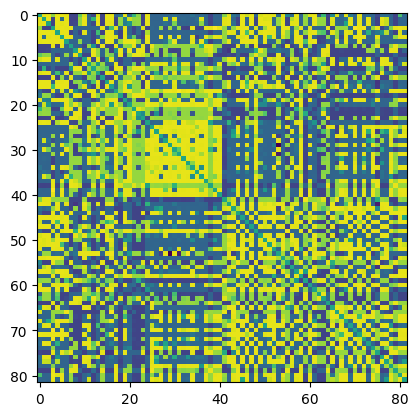

In [48]:
plt.imshow(filters[4,0,:,:])

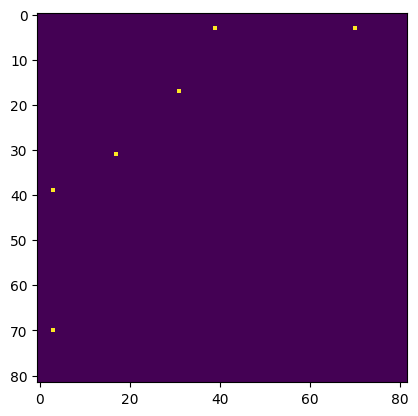

In [53]:
plt.imshow(filters[4,0,:,:] > 4)